# ROMY & FUR

## Load Libraries

In [1]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

from obspy import UTCDateTime, read_inventory
from scipy.signal import welch

from functions.get_fband_average import __get_fband_average
from functions.get_median_psd import __get_median_psd

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
def __rotate_romy_ZUV_ZNE(st, inv):

    from obspy.signal.rotate import rotate2zne

    ori_z = inv.get_orientation("BW.ROMY.10.BJZ")
    ori_u = inv.get_orientation("BW.ROMY..BJU")
    ori_v = inv.get_orientation("BW.ROMY..BJV")

    romy_z = st.select(channel="*Z")[0].data
    romy_u = st.select(channel="*U")[0].data
    romy_v = st.select(channel="*V")[0].data


    romy_z, romy_n, romy_e =rotate2zne(
                                       romy_z, ori_z['azimuth'], ori_z['dip'],
                                       romy_u, ori_u['azimuth'], ori_u['dip'],
                                       romy_v, ori_v['azimuth'], ori_v['dip'],
                                       inverse=False
                                      )

    st_new = st.copy()

    st_new.select(channel="*Z")[0].data = romy_z
    st_new.select(channel="*U")[0].data = romy_n
    st_new.select(channel="*V")[0].data = romy_e

    ch = st_new.select(channel="*U")[0].stats.channel[:2]

    st_new.select(channel="*U")[0].stats.channel = f"{ch}N"
    st_new.select(channel="*V")[0].stats.channel = f"{ch}E"

    return st_new

## Configurations

In [4]:
from andbro__read_sds import __read_sds

In [5]:
## ---------------------------------------

config = {}


config['station1'] = "BW.ROMY.10.BJZ"
config['station2'] = "GR.FUR..BHN"

config['tbeg'] = UTCDateTime("2023-09-23 01:00")

config['tend'] = UTCDateTime("2023-09-23 02:00")

config['path_to_sds1'] = archive_path+"romy_archive/"
config['path_to_sds2'] = bay_path+f"mseed_online/archive/"

config['path_to_figures'] = data_path+f"VelocityChanges/figures/"

config['path_to_inv'] = root_path+"Documents/ROMY/stationxml_ringlaser/"

In [6]:
inv1 = read_inventory(config['path_to_inv']+"dataless.seed.BW_ROMY")
inv2 = read_inventory(config['path_to_inv']+"dataless.seed.GR_FUR")

In [7]:
st1 =  __read_sds(config['path_to_sds1'], "BW.ROMY.10.BJZ", config['tbeg'], config['tend']);
st1 += __read_sds(config['path_to_sds1'], "BW.ROMY..BJU", config['tbeg'], config['tend']);
st1 += __read_sds(config['path_to_sds1'], "BW.ROMY..BJV", config['tbeg'], config['tend']);


st2 =  __read_sds(config['path_to_sds2'], "GR.FUR..BHZ", config['tbeg'], config['tend']);
st2 += __read_sds(config['path_to_sds2'], "GR.FUR..BHN", config['tbeg'], config['tend']);
st2 += __read_sds(config['path_to_sds2'], "GR.FUR..BHE", config['tbeg'], config['tend']);

st1.remove_sensitivity(inv1);
st2.remove_response(inv2, output="ACC", water_level=10);

In [8]:
st1 = __rotate_romy_ZUV_ZNE(st1, inv1)

In [9]:
st1.detrend("linear");
st2.detrend("linear");

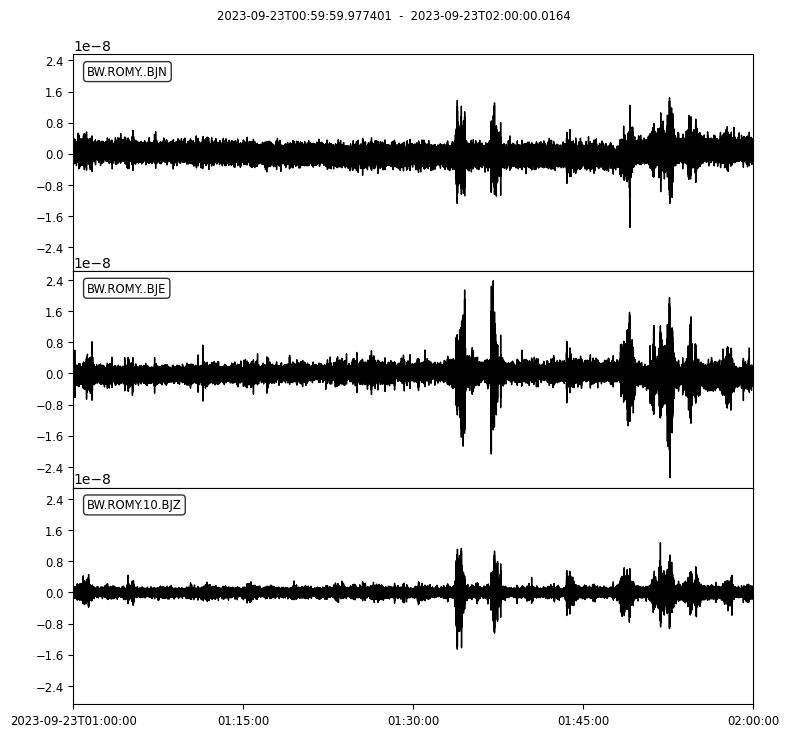

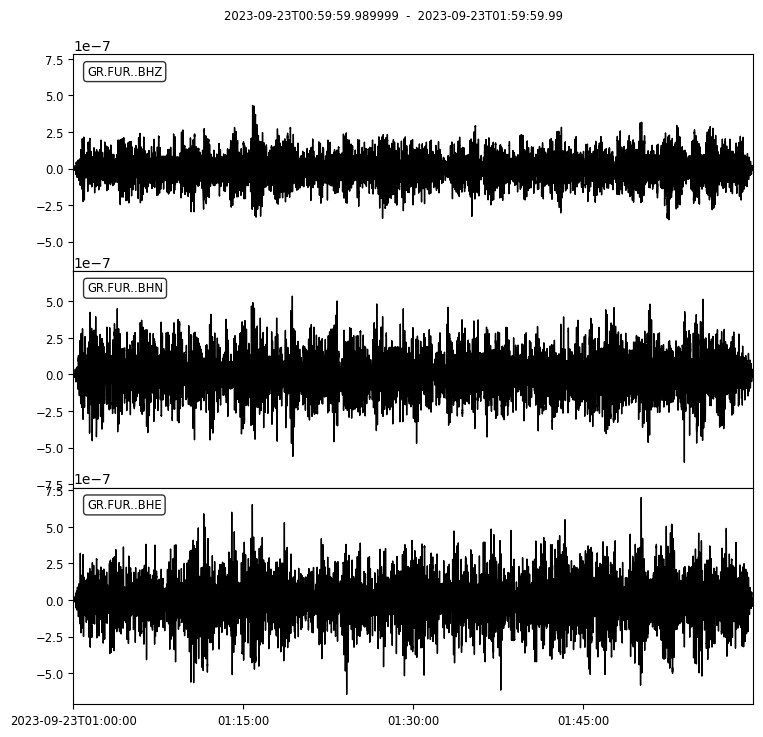

In [10]:
st1.plot();
st2.plot();

## Cross Wavelet Transform

In [11]:
from functions.get_xwt import __compute_cross_wavelet_transform

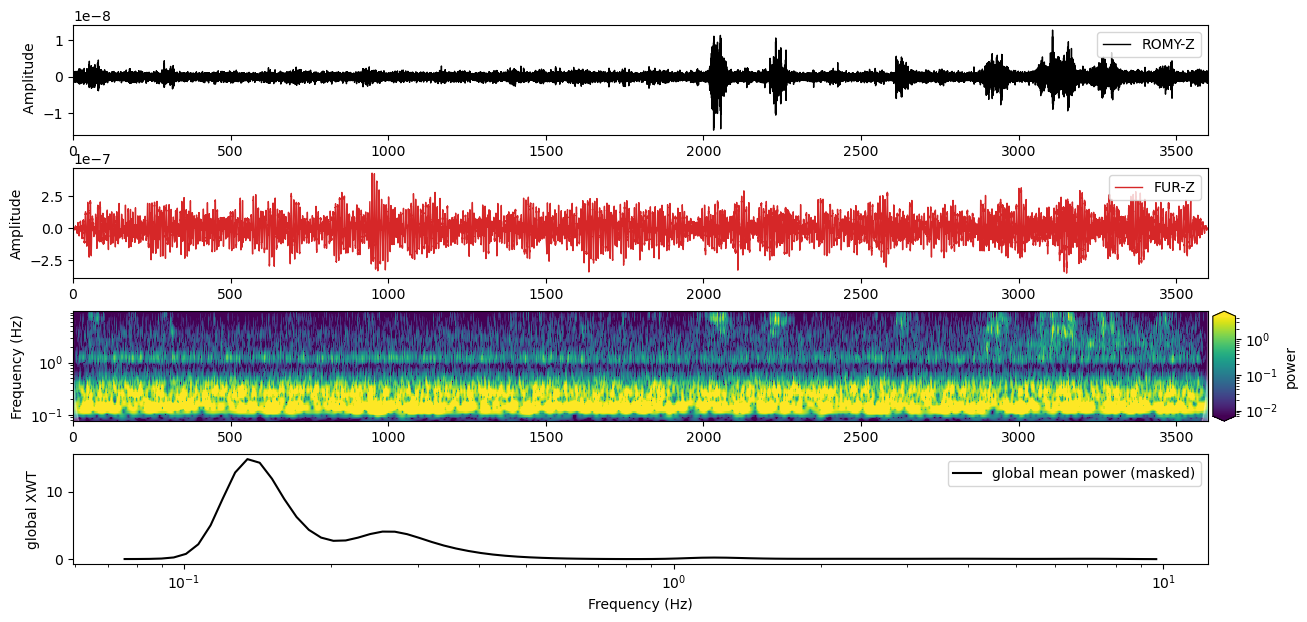

In [12]:
tt = st1[0].times()

dt = st1[0].stats.delta

dat1 = st1[0].data
dat2 = st2[0].data

out = __compute_cross_wavelet_transform(tt, dat1, dat2, dt,
                                        datalabels=["ROMY-Z", "FUR-Z"],
                                        xscale="log",
                                        cmap_scale="log",
                                        plot=True,
                                       )

out['fig'].savefig(config['path_to_figures']+f"Waveforms_FUR_ROMY_XWT_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


## Backazimuth

In [24]:
def __compute_backazimuth(st_acc, st_rot, config, wave_type="love", flim=(None, None), event=None, plot=True, show_details=False):

    """
    This method estimates a backazimuth for either
     - Love waves (vertical rotation rate and transverse acceleration) or
     - Rayleigh waves (vertical acceleration and transverse rotation rate)
    and compares it to a theoretical backazimuth computed from the source and receiver location.


    ARGUMENTS:

    - st_rot:  stream of rotation rate (ideally 3 components with channels *Z,*N,*E)
    - config:  configuration parameters as dictionary. Keywords:
               'tbeg','tend','station_latitude', 'station_longitude', 'step', 'win_length_sec', 'overlap', 'eventtime'
    - wave_type:  "love" or "rayleigh" (default: "love")
    - event:  event obspy object. Default is None. If None USGS catalog is searched for appropriate event.
    - plot:   bool (default: True). Shows plot if set True
    - show_details:  bool (default: False). Shows messages while executing if set True.

    RETURN:
    - out:  dictionary with output data. Keywords:
            'baz_mesh', 'baz_corr', 'baz_theo', 'acc_transverse', 'acc_radial', 'rot_vertical', 'event'

    >>> out = __compute_backazimuth(st_acc, st_rot, config, wave_type="love", event=None, plot=True, show_details=False)

    """

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    from numpy import ones, arange, linspace, asarray, array, meshgrid, round, shape
    from pprint import pprint
    from obspy import read, read_events, UTCDateTime
    from obspy.clients.fdsn import Client
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.signal.cross_correlation import correlate, xcorr_max
    from obspy.signal.rotate import rotate_ne_rt

    ## _______________________________
    ## check config
    keywords=['tbeg','tend','station_latitude', 'station_longitude',
              'step', 'win_length_sec', 'overlap', 'eventtime']

    for key in keywords:
        if key not in config.keys():
            print(f" -> {key} is missing in config!\n")
            pprint(keywords)
            return


    ## _______________________________
    ## Defaults
    if 'win_length_sec' not in config.keys():
        config['win_length_sec'] = .5    ## window length for correlation
    if 'step' not in config.keys():
        config['step'] = 1
    if 'overlap' not in config.keys():
        config['overlap'] = 25


    ## time period
    config['tbeg'], config['tend'] = UTCDateTime(config['tbeg']), UTCDateTime(config['tend'])

    if event is not None:
        config['eventime'] = UTCDateTime(config['eventtime'])

    ## _______________________________
    ## prepare streams
    if wave_type == "love":
        ACC = st_acc.copy().trim(config['tbeg'], config['tend'])
        ROT = st_rot.copy().trim(config['tbeg'], config['tend'])

        ## revert polarity for Z
        # for tr in ROT:
        #     if "Z" in tr.stats.channel:
        #         tr.data *= -1

    elif wave_type == "rayleigh":
        # ACC = st_acc.copy().trim(config['tbeg'], config['tend'])
        # ROT = st_rot.copy().trim(config['tbeg'], config['tend'])
        ACC = st_acc.copy()
        ROT = st_rot.copy()

    ## _______________________________
    ## get event if not provided
    if event == "auto":
        try:
            events = Client("USGS").get_events(starttime=config['eventtime']-20, endtime=config['eventtime']+20)
            if len(events) > 1:
                print(f" -> {len(events)} events found!!!")
                print(events)
                event = events[0]
        except:
            print(" -> no event found in USGS catalog")


    ## event location from event info
    if event is not None:
        config['source_latitude'] = event.origins[0].latitude
        config['source_longitude'] = event.origins[0].longitude

        if show_details:
            print(" -> event used for theoretical backazimuth:")
            print(" -> ", event.event_descriptions[0]['type'], ': ',event.event_descriptions[0]['text'] + "\n")


        ## _______________________________
        ## theoretical backazimuth and distance

        config['baz'] = gps2dist_azimuth(
                                        config['source_latitude'], config['source_longitude'],
                                        config['station_latitude'], config['station_longitude'],
                                        )
        if show_details:
            print(f" -> Epicentral distance [m]:       {round(config['baz'][0],1)}")
            print(f" -> Theoretical azimuth [deg]:     {round(config['baz'][1],1)}")
            print(f" -> Theoretical backazimuth [deg]: {round(config['baz'][2],1)}")

    ## _______________________________
    ## backazimuth estimation with Love or Rayleigh waves

    config['sampling_rate'] = int(ROT.select(channel="*Z")[0].stats.sampling_rate)

    config['num_windows'] = len(ROT.select(channel="*Z")[0]) // (int(config['sampling_rate'] * config['win_length_sec']))

    backas = linspace(0, 360 - config['step'], int(360 / config['step']))

    corrbaz = []

    ind = None

    config['num_windows']

    for i_deg in range(0, len(backas)):

        for i_win in range(0, config['num_windows']):

            ## infer indices
            idx1 = int(config['sampling_rate'] * config['win_length_sec'] * i_win)
            idx2 = int(config['sampling_rate'] * config['win_length_sec'] * (i_win + 1))

            ## add overlap
            if i_win > 0 and i_win < config['num_windows']:
                idx1 = int(idx1 - config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])
                idx2 = int(idx2 + config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])

            ## prepare traces according to selected wave type
            if wave_type == "love":

                if show_details and i_deg == 0 and i_win == 0:
                    print(f"\n -> using {wave_type} waves for estimation ...")

                ## rotate NE to RT
                R, T = rotate_ne_rt(ACC.select(channel='*N')[0].data,
                                    ACC.select(channel='*E')[0].data,
                                    backas[i_deg]
                                   )

                ## compute correlation for backazimuth
#                 corrbaz0 = xcorr(ROT.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,)
                ccorr = correlate(ROT.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
                                  demean=True, normalize='naive', method='fft')
                xshift, cc_max = xcorr_max(ccorr)

                if xshift != 0:
                    print(f" -> maximal cc not a shift=0: shift={xshift} | cc={cc_max}")

            elif wave_type == "rayleigh":

                if show_details and i_deg == 0 and i_win == 0:
                    print(f"\n -> using {wave_type} waves for estimation ...")

                ## rotate NE to RT

                R, T = rotate_ne_rt(ROT.select(channel='*N')[0].data,
                                    ROT.select(channel='*E')[0].data,
                                    backas[i_deg]
                                   )

                ## compute correlation for backazimuth
                ## vertical acceleration has to be reversed for definition of polarization reasons
                ccorr = correlate(-1*ACC.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
                                  demean=True, normalize='naive', method='fft')
#                 ccorr = correlate(ACC.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
#                                   demean=True, normalize='naive', method='fft')

                xshift, cc_max = xcorr_max(ccorr)

                if xshift != 0:
                    print(f" -> maximal cc not a shift=0: shift={xshift} | cc={cc_max}")

            else:
                print(f" -> unknown mode {wave_type}!")

            corrbaz.append(cc_max)


    corrbaz = asarray(corrbaz)
    corrbaz = corrbaz.reshape(len(backas), config['num_windows'])


    ## extract maxima
    maxcorr = array([backas[corrbaz[:, l1].argmax()] for l1 in range(0, config['num_windows'])])
    maxcorr_value = array([max(corrbaz[:, l1]) for l1 in range(0, config['num_windows'])])

    ## create mesh grid
    t_win = arange(0, config['win_length_sec']*config['num_windows']+config['win_length_sec'], config['win_length_sec'])
    t_win_center = t_win[:-1]+config['win_length_sec']/2
    mesh = meshgrid(t_win, backas)



    ## _______________________________
    ## Plotting
    def __makeplot():

        ## define figure
        fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ## parameters
        font = 12

        acc_scaling, acc_unit = 1e3, "mm/s$^2$"
        rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"

        ## create time axis
        time = linspace(0, len(ACC[0].data)/ACC[0].stats.sampling_rate, len(ACC[0].data))

        ## plot vertical rotation rate
        if wave_type == "love":
            ax[0].plot(time, ROT.select(channel="*Z")[0].data*rot_scaling, label='vertical rotation rate')
            ax[0].set_ylabel(f'vert. rot. rate \n({rot_unit})', fontsize=font)
        elif wave_type == "rayleigh":
            ax[0].plot(time, T*rot_scaling, label='transverse rotation rate')
            ax[0].set_ylabel(f'trans. rot. rate \n({rot_unit})', fontsize=font)


        ## plot transverse acceleration
        if wave_type == "love":
            ax[1].plot(time, T*acc_scaling, 'k',label='transverse acceleration')
            ax[1].set_ylabel(f'transv. acc. \n({acc_unit})', fontsize=font)
        elif wave_type == "rayleigh":
            ax[1].plot(time, ACC.select(channel="*Z")[0].data*acc_scaling, 'k',label='vertical acceleration')
            ax[1].set_ylabel(f'vert. acc. \n({acc_unit})', fontsize=font)


        ## backazimuth estimation plot
        im = ax[2].pcolormesh(t_win, backas, corrbaz[:-1,:], cmap=plt.cm.RdYlGn_r, vmin=-1, vmax=1, shading='auto')

#         ax[2].set_xlim(time[0], time[-1])
        ax[2].set_xlim(t_win[0], t_win[-1])
        ax[2].set_ylim(0, 360)
        ax[2].set_ylabel(u'estimated \n backazimuth (°)', fontsize=font)
        ax[2].set_xlabel('time (s)', fontsize=font)


        ## plot maximal correclation values
        ax[2].plot(t_win_center, maxcorr, '.k')


        if event is not None:
            ## plot theoretical Backazimuth for comparison
            xx = arange(0, config['win_length_sec'] * len(maxcorr) + 1, config['win_length_sec'])
            tba = ones(len(xx)) * config['baz'][2]
            ax[2].plot(xx, tba, lw=1.5, alpha=0.7, color="k", ls="--")


            ## add label for theoretical backazimuth
            baz_label = u'Theor. BAZ = '+str(round(config['baz'][2],0))+'°'
            if config['baz'][2] < 330:
                x_text, y_text = time[int(0.78*len(time))], config['baz'][2]+5
            else:
                x_text, y_text = time[int(0.78*len(time))], config['baz'][2]-15
                ax[2].text(x_text, y_text, baz_label, color='k', fontsize=font-2)


            ## epicentral distance
            edist = round(config['baz'][0]/1000, 1)


        ## adjust title
        date = config['tbeg'].date
        t1, t2 = str(config['tbeg'].time).split(".")[0], str(config['tend'].time).split(".")[0]
        try:
            if flim[0] is not None and flim[1] is not None:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC | Epicentral Distance = {edist} km | {flim[0]}-{flim[1]} Hz", fontsize=font-1)
            else:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC | Epicentral Distance = {edist} km", fontsize=font-1)
        except:
            try:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC | Twin = {config['win_length_sec']} s | {flim[0]}-{flim[1]} Hz | {round(1/flim[1], 1)}-{round(1/flim[0],1)} s", fontsize=font-1)
            except:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC", fontsize=font-1)

        ## tune tick size
        for i in range(3):
            ax[i].tick_params(axis="y", labelsize=font-1)
            ax[i].tick_params(axis="x", labelsize=font-1)
            ax[i].set_xlim(time[0], time[-1])

        ## add legends
        ax[0].legend(loc=1, fontsize=font-2)
        ax[1].legend(loc=1, fontsize=font-2)

        ## adjust tick label style
        ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))


        ## add colorbar
        cax = ax[2].inset_axes([1.01, 0., 0.02, 1])
        cb1 = plt.colorbar(im, ax=ax[2], cax=cax)
        cb1.set_label("CC Coefficient", fontsize=font)

        plt.show();
        return fig

    if plot:
        fig = __makeplot();


    ## _______________________________
    ## prepare output

    output = {}

    output['baz_mesh'] = mesh
    output['baz_corr'] = corrbaz
    output['acc'] = ACC
    output['rot'] = ROT
    output['event'] = event
    output['cc_max_t'] = t_win_center
    output['cc_max_y'] = maxcorr
    output['cc_max'] = maxcorr_value

    if event is not None:
        output['baz_theo'] = config['baz'][2]

    if plot:
        output['fig'] = fig

    return output

## End of File

In [14]:
acc = st2.copy();
rot = st1.copy();

fmin, fmax = 1/10, 1/7

acc = acc.detrend("linear");
acc = acc.taper(0.01);
acc = acc.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

rot = rot.detrend("linear");
rot = rot.taper(0.01);
rot = rot.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

In [15]:
conf = {}

conf['eventtime'] = config['tbeg']

conf['tbeg'] = config['tbeg']
conf['tend'] = config['tend']

conf['station_longitude'] = 11.275501
conf['station_latitude']  = 48.162941

## specify window length for baz estimation in seconds
conf['win_length_sec'] = 2/fmin

## define an overlap for the windows in percent (50 -> 50%)
conf['overlap'] = 50

## specify steps for degrees of baz
conf['step'] = 1

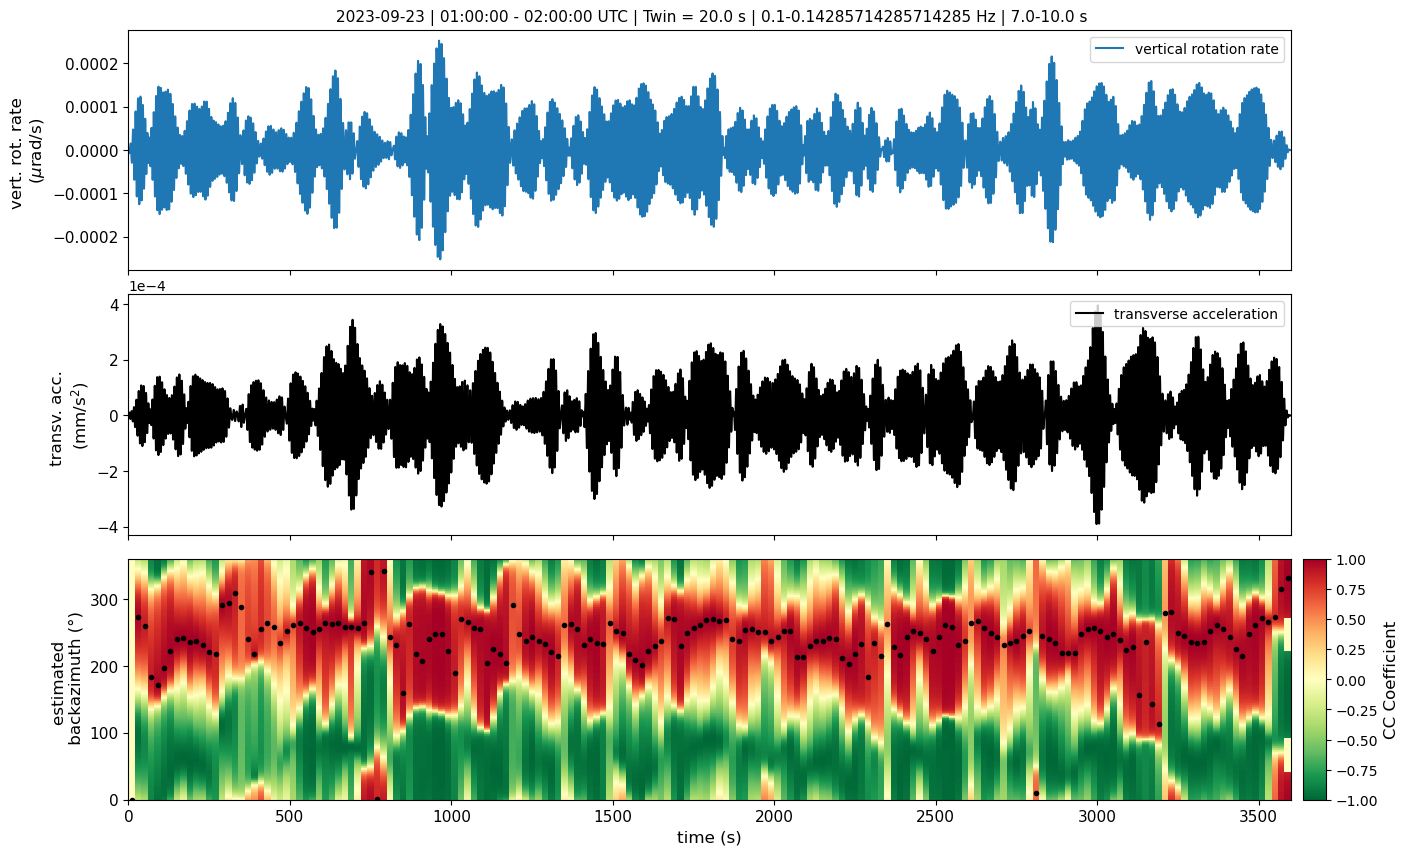

In [16]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            conf,
                            wave_type='love',
                            event=None,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
                            )

out['fig'].savefig(config['path_to_figures']+f"Waveforms_FUR_ROMY_BAZ_Love_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


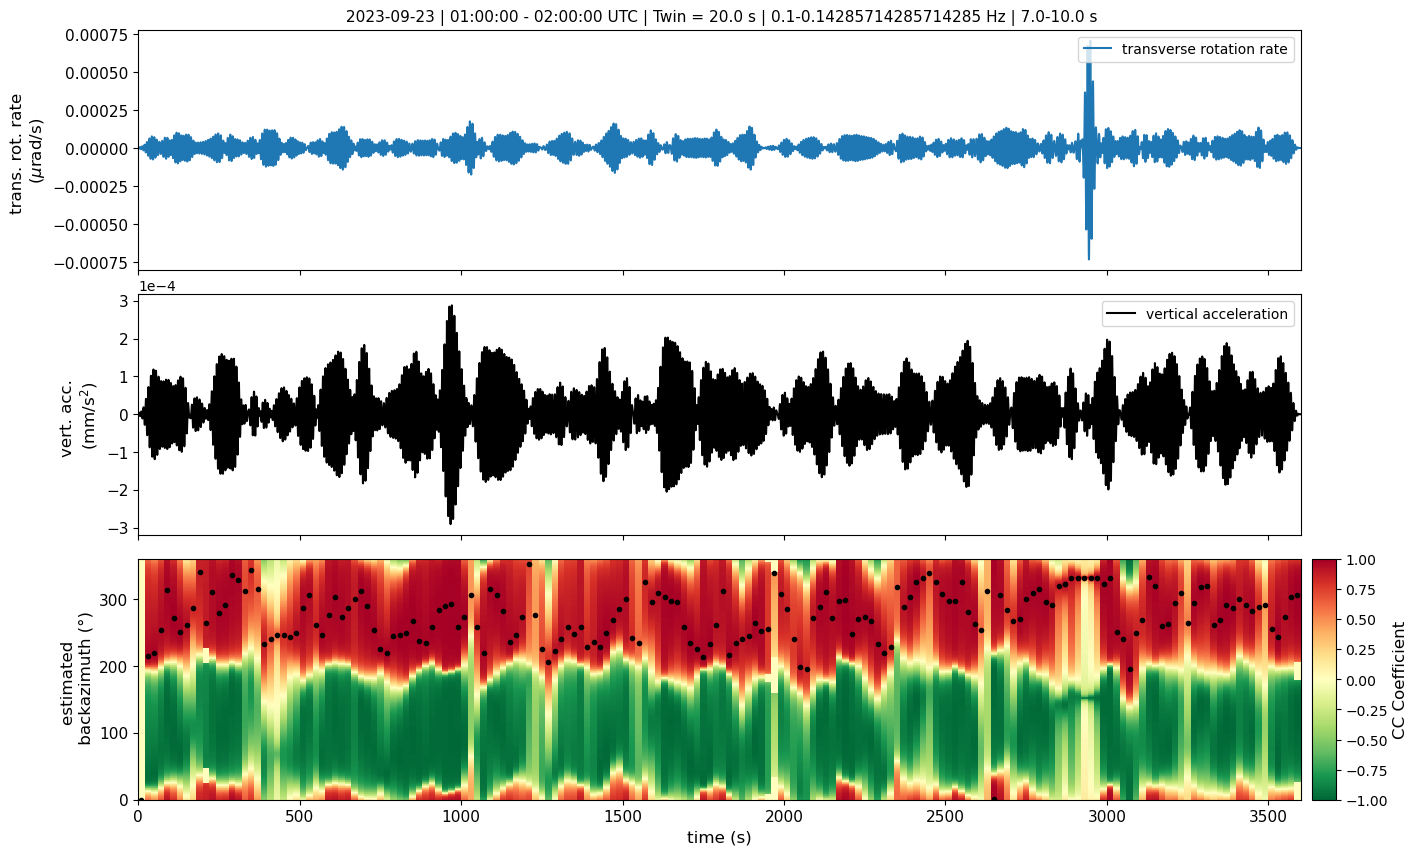

In [17]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            conf,
                            wave_type='rayleigh',
                            event=None,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
                            )

out['fig'].savefig(config['path_to_figures']+f"Waveforms_FUR_ROMY_BAZ_Rayleigh_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


In [84]:
def __compare_backazimuth_codes(rot0, acc0, cat_event, fmin, fmax, cc_thres=None, plot=False):

    import scipy.stats as sts
    import matplotlib.pyplot as plt

    from numpy import ones, linspace, histogram, concatenate, average, argmax, isnan, sqrt, cov, nan, array, arange
    from obspy import UTCDateTime    
    from obspy.signal.rotate import rotate_ne_rt
    from functions.compute_backazimuth import __compute_backazimuth
    from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

    rot = rot0.copy()
    acc = acc0.copy()

    rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
    acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

    config = {}

    config['tbeg'] = rot[0].stats.starttime
    config['tend'] = rot[0].stats.endtime

    ## Eventtime
    if cat_event is not None:
        config['eventtime'] = UTCDateTime(cat_event.origins[0].time)
    else:
        config['eventtime'] = UTCDateTime(rot[0].stats.starttime)


    ## specify coordinates of station
    config['station_longitude'] =  -116.455439
    config['station_latitude']  = 33.6106

    ## specify window length for baz estimation in seconds
    config['win_length_sec'] = 2/fmin

    ## define an overlap for the windows in percent (50 -> 50%)
    config['overlap'] = 75

    ## specify steps for degrees of baz
    config['step'] = 1


    out1 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='rayleigh',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out2 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='love',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    if cat_event is None:
        out2['baz_theo'] = 0

    out3 = __compute_backazimuth_tangent(
                                        rot,
                                        acc,
                                        win_time_s= config['win_length_sec'],
                                        overlap=config['overlap']/100,
                                        baz_theo=out2['baz_theo'],
                                        cc_thres=0,
                                        plot=False,
    )

    ## filter according to cc-threshold
    if cc_thres:
        for ii, _cc in enumerate(out1['cc_max']):
            if abs(_cc) <= cc_thres:
                out1['cc_max'][ii], out1['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out2['cc_max']):
            if abs(_cc) <= cc_thres:
                out2['cc_max'][ii], out2['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out3['ccoef']):
            if abs(_cc) <= cc_thres:
                out3['ccoef'][ii], out3['baz_est'][ii] = nan, nan



    if plot:

        NN = 6
        rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
        trans_scaling, trans_unit = 1e3, r"mm/s$^2$"

        font = 12

        fig1, ax = plt.subplots(NN, 1, figsize=(15, 10), sharex=True)

        plt.subplots_adjust(hspace=0.2)

        hz = acc.select(channel="*HZ")[0]
        hn = acc.select(channel="*HN")[0]
        he = acc.select(channel="*HE")[0]

        jz = rot.select(channel="*JZ")[0]
        jn = rot.select(channel="*JN")[0]
        je = rot.select(channel="*JE")[0]

        hr, ht = rotate_ne_rt(hn.data, he.data, out3['baz_theo'])
        jr, jt = rotate_ne_rt(jn.data, je.data, out3['baz_theo'])

        ## reverse polarity of transverse rotation!!
        jt *= -1

        t1, t2 = hz.times().min(), hz.times().max()

        ax[0].plot(hz.times(), ht*trans_scaling, 'black', label=f"PFO.T")
        ax[1].plot(hz.times(), hr*trans_scaling, 'black', label=f"PFO.R")
        ax[2].plot(hz.times(), hz.data*trans_scaling, 'black', label=f"PFO.Z")

        ax[0].set_ylim(-max(abs(ht*trans_scaling)), max(abs(ht*trans_scaling)))
        ax[1].set_ylim(-max(abs(hr*trans_scaling)), max(abs(hr*trans_scaling)))
        ax[2].set_ylim(-max(abs(hz.data*trans_scaling)), max(abs(hz.data*trans_scaling)))

        ax00 = ax[0].twinx()
        ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"BSPF.Z")

        ax11 = ax[1].twinx()
        ax11.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x BSPF.T")

        ax22 = ax[2].twinx()
        ax22.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x BSPF.T")

        ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
        ax11.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))
        ax22.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))

        cmap = plt.get_cmap("viridis", 10)

        ca3 = ax[3].scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca4 = ax[4].scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca5 = ax[5].scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        cax3 = ax[3].inset_axes([1.01, 0., 0.02, 1])
        cb3 = plt.colorbar(ca3, ax=ax[3], cax=cax3)
        cb3.set_label("CC-Coeff.", fontsize=font)

        cax4 = ax[4].inset_axes([1.01, 0., 0.02, 1])
        cb4 = plt.colorbar(ca4, ax=ax[4], cax=cax4)
        cb4.set_label("CC-Coeff.", fontsize=font)

        cax5 = ax[5].inset_axes([1.01, 0., 0.02, 1])
        cb5 = plt.colorbar(ca5, ax=ax[5], cax=cax5)
        cb5.set_label("CC-Coeff.", fontsize=font)

        ax[3].set_ylabel(f"Rayleigh Baz.(°)")
        ax[4].set_ylabel(f"Love Baz.(°)")
        ax[5].set_ylabel(f"CoVar. Baz.(°)")


        ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
        ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

        ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
        ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

        ax[2].set_yticks(linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
        ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))

        for i in [0,1,2]:
            ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            ax[i].legend(loc=1)
            ax[i].set_ylabel(f"a ({trans_unit})")

        for i in [3,4,5]:
            ax[i].set_ylim(-5, 365)
            ax[i].set_yticks(range(0,360+60,60))
            ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            # ax[i].set_ylabel(f"Baz.(°)")
            # ax[i].plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)
            # ax[i].fill_between([t1, t2], ones(2)*out3['baz_theo']-10, ones(2)*out3['baz_theo']+10, lw=1.5, alpha=0.5, color="grey", ls="--", zorder=1)

        for aaxx in [ax00, ax11, ax22]:
            aaxx.tick_params(axis='y', colors="darkred")
            aaxx.set_ylabel(f"$\omega$ ({rot_unit})", color="darkred")
            aaxx.legend(loc=4)

        ax[0].set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {fmin}-{fmax} Hz | T = {config['win_length_sec']} s | {config['overlap']} % overlap")

        ax[5].set_xlabel("Time (s)")

        plt.show();



    ## compute statistics
    deltaa = 10
    angles = arange(0, 365, deltaa)
    angles2 = arange(0, 365, 1)

    ## ______________________________________
    ## Rayleigh
    try:
        baz_rayleigh_no_nan = out1['cc_max_y'][~isnan(out1['cc_max_y'])]
        cc_rayleigh_no_nan = out1['cc_max'][~isnan(out1['cc_max'])]

        hist = histogram(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)

        baz_rayleigh_mean = round(average(baz_rayleigh_no_nan, weights=cc_rayleigh_no_nan), 0)
        baz_rayleigh_std = sqrt(cov(baz_rayleigh_no_nan, aweights=cc_rayleigh_no_nan))

        # baz_rayleigh_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde1 = sts.gaussian_kde(baz_rayleigh_no_nan, weights=baz_rayleigh_no_nan)
        baz_rayleigh_max = angles2[argmax(kde1.pdf(angles2))]

        ## ______________________________________
        ## Love
        baz_love_no_nan = out2['cc_max_y'][~isnan(out2['cc_max_y'])]
        cc_love_no_nan = out2['cc_max'][~isnan(out2['cc_max'])]

        hist = histogram(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)

        baz_love_mean = round(average(baz_love_no_nan, weights=cc_love_no_nan), 0)
        baz_love_std = sqrt(cov(baz_love_no_nan, aweights=cc_love_no_nan))

        # baz_love_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde2 = sts.gaussian_kde(baz_love_no_nan, weights=cc_love_no_nan)
        baz_love_max = angles2[argmax(kde2.pdf(angles2))]

        ## ______________________________________
        ## Tangent
        baz_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]
        cc_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]

        hist = histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)

        baz_tangent_mean = round(average(baz_tangent_no_nan, weights=cc_tangent_no_nan), 0)
        baz_tangent_std = sqrt(cov(baz_tangent_no_nan, aweights=cc_tangent_no_nan))

        # baz_tangent_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde3 = sts.gaussian_kde(baz_tangent_no_nan, weights=cc_tangent_no_nan)
        baz_tangent_max = angles2[argmax(kde3.pdf(angles2))]

    except Exception as e:
        print(e)
        pass

    if plot:

        fig2, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].hist(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)
        ax[0].plot(angles, kde1.pdf(angles), c='C1', lw=2, label='KDE')
        ax[0].axvline(baz_rayleigh_max, color="r")
        # ax[0].axvline(baz_rayleigh_mean, color="g")
        ax[0].set_title("Rayleigh")
        ax[0].set_xlabel("Backazimuth")
        ax[0].set_ylabel("Density")

        ax[1].hist(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)
        ax[1].plot(angles, kde2.pdf(angles), c='C1', lw=2, label='KDE')
        ax[1].axvline(baz_love_max, color="r")
        # ax[1].axvline(baz_love_mean, color="g")
        ax[1].set_title("Love")
        ax[1].set_xlabel("Backazimuth")

        ax[2].hist(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)
        ax[2].plot(angles, kde3.pdf(angles), c='C1', lw=2, label='KDE')
        ax[2].axvline(baz_tangent_max, color="r")
        # ax[2].axvline(baz_tangent_mean, color="g")
        ax[2].set_title("Co.Var.")
        ax[2].set_xlabel("Backazimuth")
        plt.show();


    if plot:

        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec

        Ncol, Nrow = 8, 6

        fig = plt.figure(figsize=(15, 10))

        gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.15)

        ax0 = fig.add_subplot(gs[0, :])
        ax1 = fig.add_subplot(gs[1, :])
        ax2 = fig.add_subplot(gs[2, :])

        ax3 = fig.add_subplot(gs[3, :])
        ax4 = fig.add_subplot(gs[4, :])
        ax5 = fig.add_subplot(gs[5, :])

        ax6 = fig.add_subplot(gs[3, 7:])
        ax7 = fig.add_subplot(gs[4, 7:])
        ax8 = fig.add_subplot(gs[5, 7:])

        ax6.set_axis_off()
        ax7.set_axis_off()
        ax8.set_axis_off()

        for _ax in [ax0, ax1, ax2, ax3, ax4]:
            _ax.set_xticklabels([])

        rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
        trans_scaling, trans_unit = 1e3, r"mm/s$^2$"

        font = 12

        hz = acc.select(channel="*HZ")[0]
        hn = acc.select(channel="*HN")[0]
        he = acc.select(channel="*HE")[0]

        jz = rot.select(channel="*JZ")[0]
        jn = rot.select(channel="*JN")[0]
        je = rot.select(channel="*JE")[0]

        hr, ht = rotate_ne_rt(hn.data, he.data, out3['baz_theo'])
        jr, jt = rotate_ne_rt(jn.data, je.data, out3['baz_theo'])

        ## reverse polarity of transverse rotation!!
        jt *= -1

        ax0.plot(hz.times(), ht*trans_scaling, 'black', label=f"PFO.T")
        ax1.plot(hz.times(), hr*trans_scaling, 'black', label=f"PFO.R")
        ax2.plot(hz.times(), hz.data*trans_scaling, 'black', label=f"PFO.Z")

        ax0.set_ylim(-max(abs(ht*trans_scaling)), max(abs(ht*trans_scaling)))
        ax1.set_ylim(-max(abs(hr*trans_scaling)), max(abs(hr*trans_scaling)))
        ax2.set_ylim(-max(abs(hz.data*trans_scaling)), max(abs(hz.data*trans_scaling)))

        ax00 = ax0.twinx()
        ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"BSPF.Z")

        ax11 = ax1.twinx()
        ax11.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x BSPF.T")

        ax22 = ax2.twinx()
        ax22.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x BSPF.T")

        ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
        ax11.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))
        ax22.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))

        cmap = plt.get_cmap("viridis", 10)

        ca3 = ax3.scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca4 = ax4.scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca5 = ax5.scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        cax3 = ax3.inset_axes([1.01, 0., 0.02, 1])
        cb3 = plt.colorbar(ca3, ax=ax3, cax=cax3)
        cb3.set_label("CC-Coeff.", fontsize=font)

        cax4 = ax4.inset_axes([1.01, 0., 0.02, 1])
        cb4 = plt.colorbar(ca4, ax=ax4, cax=cax4)
        cb4.set_label("CC-Coeff.", fontsize=font)

        cax5 = ax5.inset_axes([1.01, 0., 0.02, 1])
        cb5 = plt.colorbar(ca5, ax=ax5, cax=cax5)
        cb5.set_label("CC-Coeff.", fontsize=font)

        ax3.set_ylabel(f"Rayleigh Baz.(°)")
        ax4.set_ylabel(f"Love Baz.(°)")
        ax5.set_ylabel(f"CoVar. Baz.(°)")

        ax66 = ax6.twinx()
        ax66.hist(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out1['cc_max'], orientation="horizontal", density=True, color="lightgrey")
        ax66.plot(kde1.pdf(angles), angles, c="tab:red", lw=2, label='KDE')
        ax66.axhline(baz_rayleigh_max, color="tab:red", ls="--")
        ax66.set_axis_off()
        ax66.yaxis.tick_right()
        ax66.invert_xaxis()

        ax77 = ax7.twinx()
        ax77.hist(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out2['cc_max'], orientation="horizontal", density=True, color="lightgrey")
        ax77.plot(kde2.pdf(angles), angles, c="tab:red", lw=2, label='KDE')
        ax77.axhline(baz_love_max, color="tab:red", ls="--")
        ax77.set_axis_off()
        ax77.yaxis.tick_right()
        ax77.invert_xaxis()

        ax88 = ax8.twinx()
        ax88.hist(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out3['ccoef'], orientation="horizontal", density=True, color="lightgrey")
        ax88.plot(kde3.pdf(angles), angles, c="tab:red", lw=2, label='KDE')
        ax88.axhline(baz_tangent_max, color="tab:red", ls="--")
        ax88.set_axis_off()
        ax88.yaxis.tick_right()
        ax88.invert_xaxis()


        ax0.set_yticks(linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax0.get_yticks())))
        ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax0.get_yticks())))

        ax1.set_yticks(linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax1.get_yticks())))
        ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax1.get_yticks())))

        ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax2.get_yticks())))
        ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax2.get_yticks())))

        for _ax in [ax0, ax1, ax2]:
            _ax.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            _ax.legend(loc=1)
            _ax.set_ylabel(f"a ({trans_unit})")
            _ax.set_xlim(0, 4000)

        for _ax in [ax3 ,ax4, ax5]:
            _ax.set_ylim(-5, 365)
            _ax.set_yticks(range(0, 360+60,60))
            _ax.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            _ax.set_xlim(0, 4000)
            # _ax.set_ylabel(f"Baz.(°)")
            # _ax.plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)
            # _ax.fill_between([t1, t2], ones(2)*out3['baz_theo']-10, ones(2)*out3['baz_theo']+10, lw=1.5, alpha=0.5, color="grey", ls="--", zorder=1)

        for aaxx in [ax00, ax11, ax22]:
            aaxx.tick_params(axis='y', colors="darkred")
            aaxx.set_ylabel(f"$\omega$ ({rot_unit})", color="darkred")
            aaxx.legend(loc=4)

        ax0.set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {fmin}-{fmax} Hz | T = {config['win_length_sec']} s | {config['overlap']} % overlap")

        ax5.set_xlabel("Time (s)")

        plt.show();

    ## prepare output directory
    out = {}
    out['baz_theo'] = round(out2['baz_theo'], 0)
    out['baz_angles'] = angles
    out['baz_tangent_max'] = baz_tangent_max
    out['baz_tangent_mean'] = baz_tangent_mean
    out['baz_tangent_std'] = baz_tangent_std
    out['baz_rayleigh_max'] = baz_rayleigh_max
    out['baz_rayleigh_mean'] = baz_rayleigh_mean
    out['baz_rayleigh_std'] = baz_rayleigh_std
    out['baz_love_max'] = baz_love_max
    out['baz_love_mean'] = baz_love_mean
    out['baz_love_std'] = baz_love_std


    if plot:
        out['fig1'] = fig1
        out['fig2'] = fig2

    return out

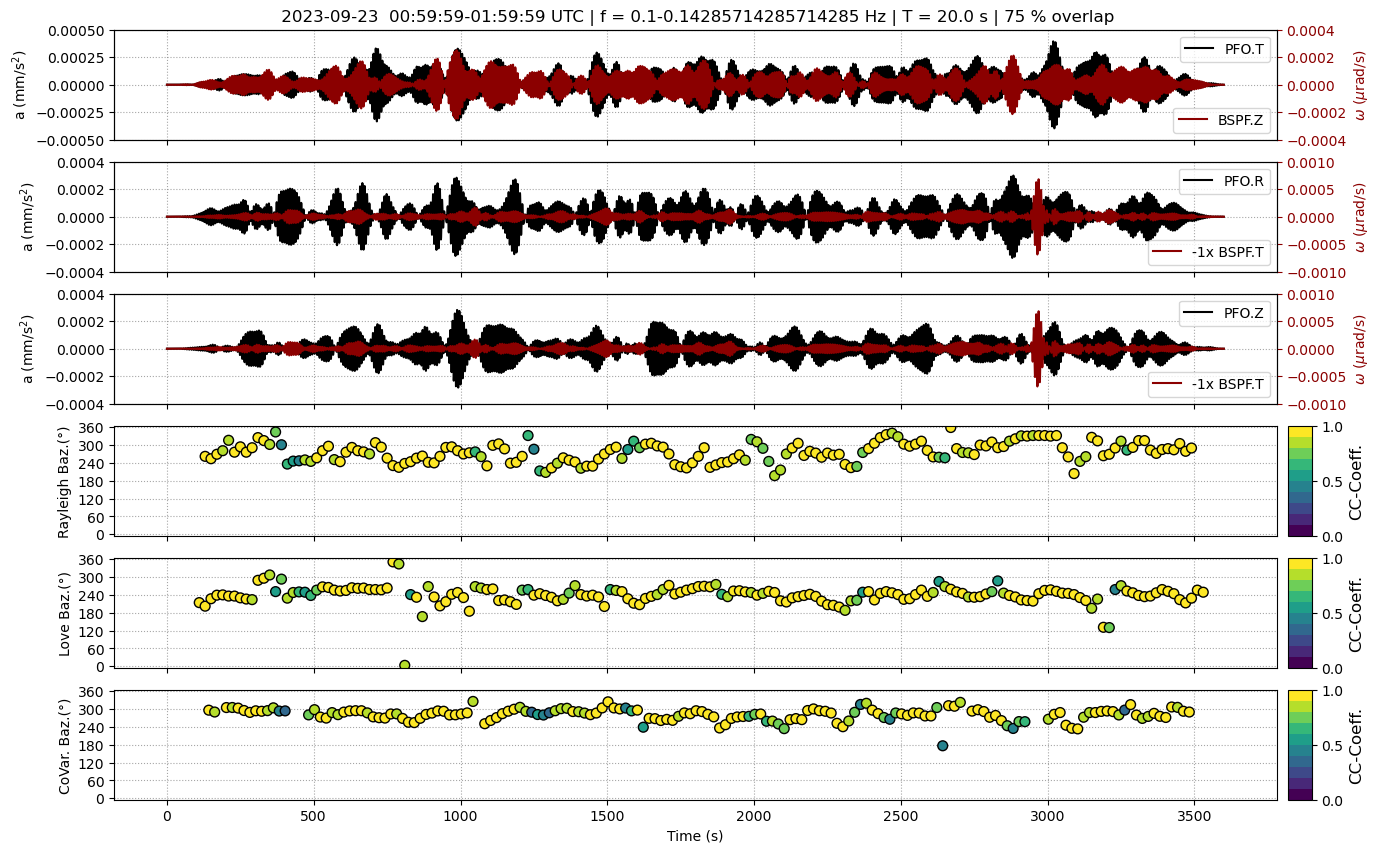

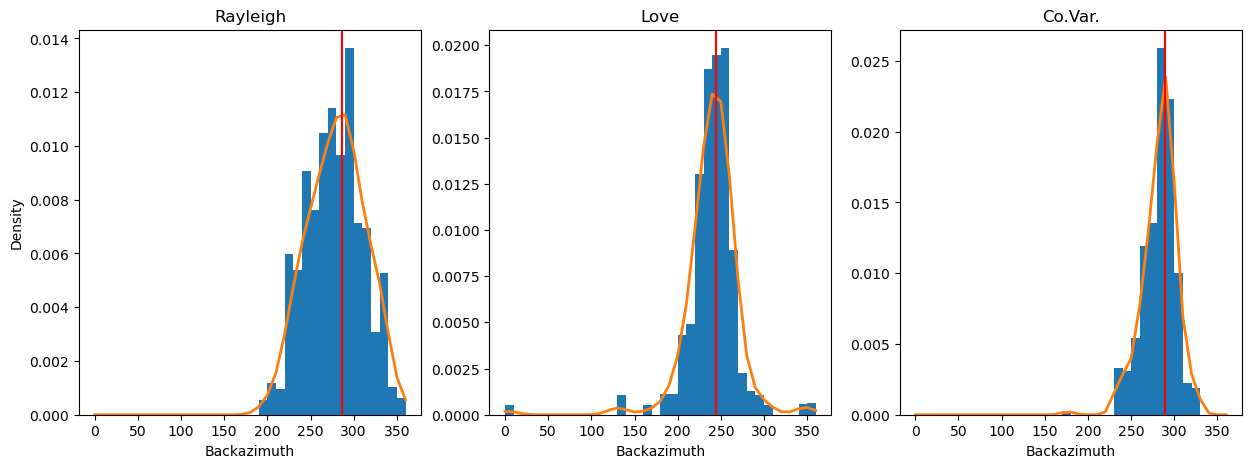

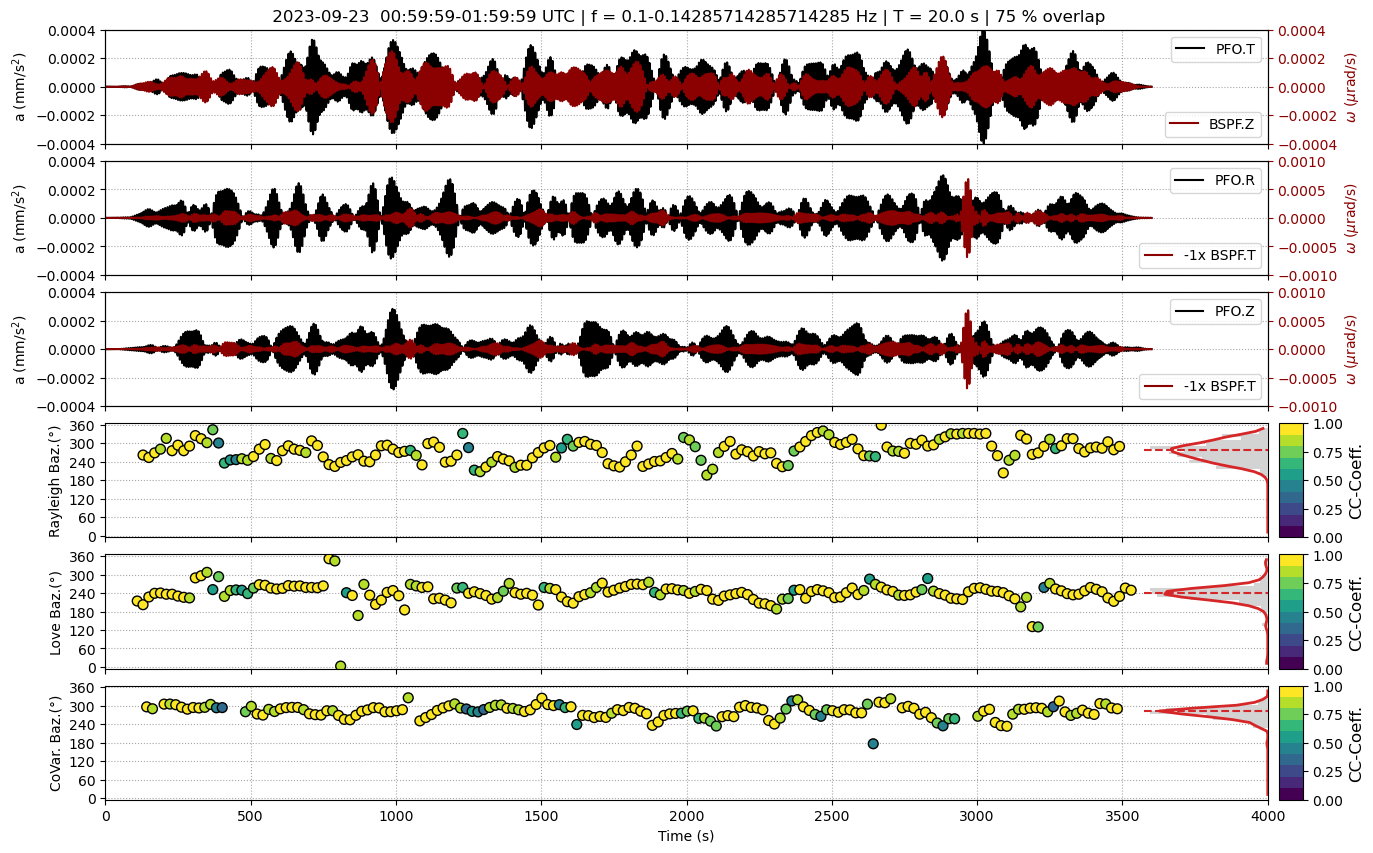

In [85]:

out = __compare_backazimuth_codes(rot, acc, None, fmin, fmax, cc_thres=0.2, plot=True);


# out['fig1'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05);
# out['fig2'].savefig(config['path_to_figs']+f"BSPF_M42_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_his2.png", dpi=200, bbox_inches='tight', pad_inches=0.05);


NameError: name 'acc' is not defined